# Opinion Mining of E-Commerce Reviews

Course: CS-516 – Information Retrieval and Text Mining (ITU, Fall 2025)  \nTeam: Aqsa Taqdees, Ghulam Ruqia, Yusra Qayyum

This notebook mirrors the Python modules for EDA, training (with light hyperparameter tuning), diagnostics, and inference. Run top-to-bottom after placing `data/raw/245_1.csv`.

## Goals
- Inspect raw reviews and label mapping.
- Run cleaning (contractions expansion, negation-aware stopwords, lemmatization) and visualize distributions.
- Build word + character TF-IDF features; tune Linear SVM (C grid) and SGD hinge (alpha grid).
- Evaluate with confusion matrices, PR/ROC curves, top features, and error samples.
- Demo inference on unseen text; artifacts saved by the pipeline are reused for CLI inference.

## Setup
- Uses the project virtual environment with requirements from `requirements.txt`.
- Confirm `data/raw/245_1.csv` exists (path is set in `config/config.yaml`).
- Figures are saved to `assets/` and also shown inline here.

In [40]:
from pathlib import Path
import sys

# Resolve project root that contains src/models.py
known_root = Path("/home/saad-alam/Documents/assignments/Yusra's_ir_project").resolve()
root = known_root if (known_root / 'src' / 'models.py').exists() else Path.cwd().resolve()
for _ in range(5):
    if (root / 'src' / 'models.py').exists():
        break
    root = root.parent
if not (root / 'src' / 'models.py').exists():
    raise FileNotFoundError('Could not locate project root containing src/models.py')
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
print('Project root on sys.path:', root)

Project root on sys.path: /home/saad-alam/Documents/assignments/Yusra's_ir_project


In [41]:

from pathlib import Path
import sys
import importlib
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from utils.config_loader import load_config
from utils.visualization import (
    plot_rating_distribution,
    plot_class_distribution,
    plot_wordcloud,
    plot_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
    plot_length_distribution,
    plot_top_features,
)

# Force import from the project src/ (helps if another "src" is on sys.path)
models_mod = importlib.import_module('src.models')
models_mod = importlib.reload(models_mod)
print('Loaded src.models from', models_mod.__file__)

from src.data_loader import load_raw_dataset
from src.preprocessing import preprocess_dataframe
from src.features import build_tfidf_features, transform_texts
from src.models import (
    train_test_split_data,
    train_svm,
    train_sgd,
    tune_linear_svc,
    tune_sgd_classifier,
)


Loaded src.models from /home/saad-alam/Documents/assignments/Yusra's_ir_project/src/models.py


## 1) Load raw data

In [42]:
config = load_config()
text_col = config['data']['text_column']
rating_col = config['data']['rating_column']
did_purchase_col = config['data']['did_purchase_column']
raw_path = Path(config['paths']['raw_data'])

print(f'Loading raw data from: {raw_path.resolve()}')
df_raw = load_raw_dataset(raw_path)
print(f'Raw shape: {df_raw.shape}')
df_raw[[text_col, rating_col, did_purchase_col]].head()

Loading raw data from: /home/saad-alam/Documents/assignments/Yusra's_ir_project/data/raw/245_1.csv
Raw shape: (71044, 25)


reviews.text  reviews.rating  \
0  i love this album. it's very good. more to the...               5   
1  Good flavor. This review was collected as part...               5   
2                                       Good flavor.               5   
3  I read through the reviews on here before look...               1   
4  My husband bought this gel for us. The gel cau...               1   

  reviews.didPurchase  
0                 NaN  
1                True  
2                True  
3               False  
4               False

## 2) Preprocess and sentiment mapping
- Expand contractions, keep negation cues (no/not/never), remove punctuation/numbers.
- Lemmatize (fallback to stemming if WordNet is unavailable).
- Map ratings 1–2 → Unhappy, 3 → Ok, 4–5 → Happy.

In [43]:
X_text, y = preprocess_dataframe(
    df_raw,
    text_col=text_col,
    rating_col=rating_col,
    did_purchase_col=did_purchase_col,
    config=config,
)
print('Post-cleaning samples:', len(X_text))
pd.DataFrame({'text_clean': X_text.head(), 'sentiment': y.head()})

Post-cleaning samples: 71008


text_clean sentiment
0  love album good hip hop side current pop sound...     Happy
1        good flavor review collected part promotion     Happy
2                                        good flavor     Happy
3  read reviews looking buying one couples lubric...   Unhappy
4  husband bought gel us gel caused irritation fe...   Unhappy

## 3) Visualize distributions

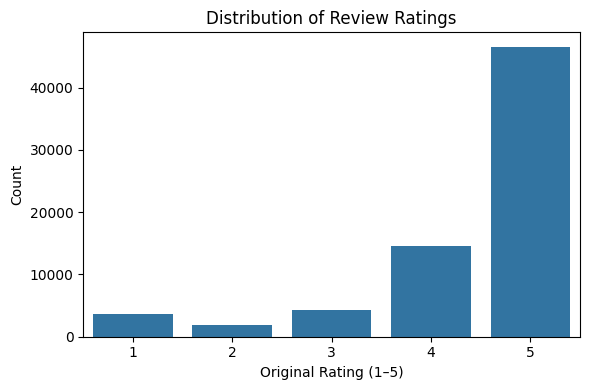

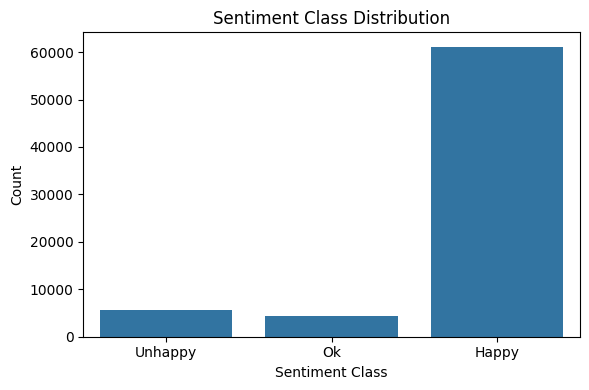

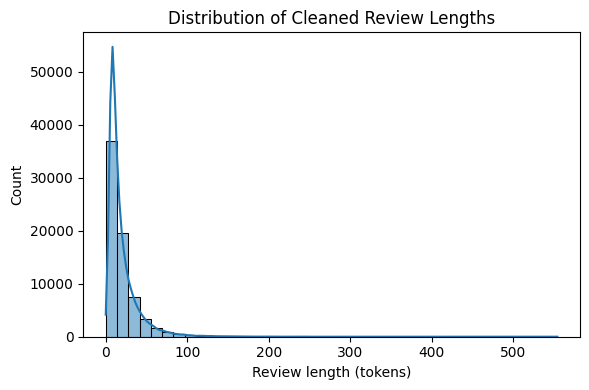

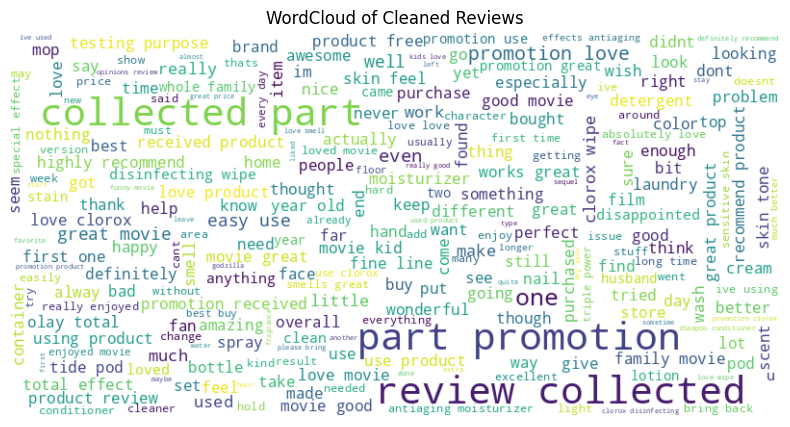

In [44]:
plot_rating_distribution(df_raw[rating_col])
plot_class_distribution(y)
plot_length_distribution(X_text)
plot_wordcloud(X_text, 'WordCloud of Cleaned Reviews')

## 4) Features, split, and light hyperparameter tuning

In [45]:
# Build TF-IDF features (char + word)
X_all, word_vec, char_vec = build_tfidf_features(
    X_text, config['features']['word_tfidf'], config['features']['char_tfidf']
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split_data(X_all, y, config['split'])
_, text_test, _, _ = train_test_split_data(X_text, y, config['split'])

# Inner validation split for tuning
X_train_inner, X_val, y_train_inner, y_val = train_test_split(
    X_train, y_train,
    test_size=config['split'].get('val_size', 0.1),
    random_state=config['split']['random_state'],
    shuffle=True, stratify=y_train
)

svm_grid = config['models']['svm'].get('grid_C', [1.0])
sgd_grid = config['models']['sgd'].get('grid_alpha', [1e-4])
svm_tuned, best_c = tune_linear_svc(X_train_inner, y_train_inner, X_val, y_val, config['models']['svm'], svm_grid)
sgd_tuned, best_alpha = tune_sgd_classifier(X_train_inner, y_train_inner, X_val, y_val, config['models']['sgd'], sgd_grid)
print('Best LinearSVC C:', best_c)
print('Best SGD alpha:', best_alpha)

svm_model = train_svm(X_train, y_train, {**config['models']['svm'], 'C': best_c})
sgd_model = train_sgd(X_train, y_train, {**config['models']['sgd'], 'alpha': best_alpha})

/home/saad-alam/Documents/assignments/Yusra's_ir_project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/saad-alam/Documents/assignments/Yusra's_ir_project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/saad-alam/Documents/assignments/Yusra's_ir_project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/saad-alam/Documents/assignments/Yusra's_ir_project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best LinearSVC C: 0.5
Best SGD alpha: 0.0001


/home/saad-alam/Documents/assignments/Yusra's_ir_project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## 5) Evaluation and diagnostics

SVM report
              precision    recall  f1-score   support

       Happy       0.95      0.95      0.95     18333
          Ok       0.41      0.38      0.40      1310
     Unhappy       0.73      0.73      0.73      1660

    accuracy                           0.90     21303
   macro avg       0.70      0.69      0.69     21303
weighted avg       0.90      0.90      0.90     21303

SGD report
              precision    recall  f1-score   support

       Happy       0.95      0.96      0.95     18333
          Ok       0.43      0.38      0.40      1310
     Unhappy       0.73      0.72      0.73      1660

    accuracy                           0.90     21303
   macro avg       0.70      0.68      0.69     21303
weighted avg       0.90      0.90      0.90     21303



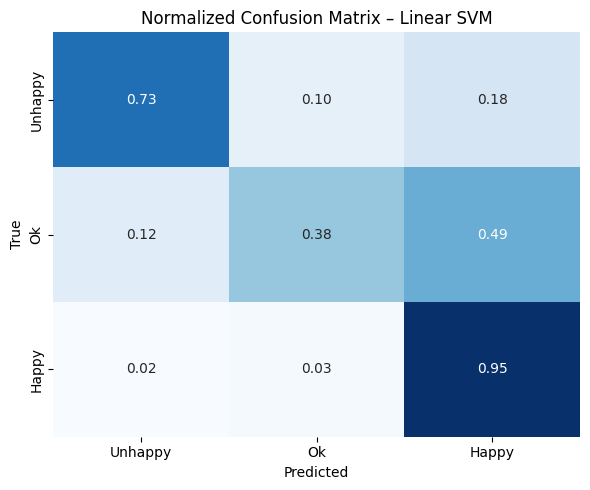

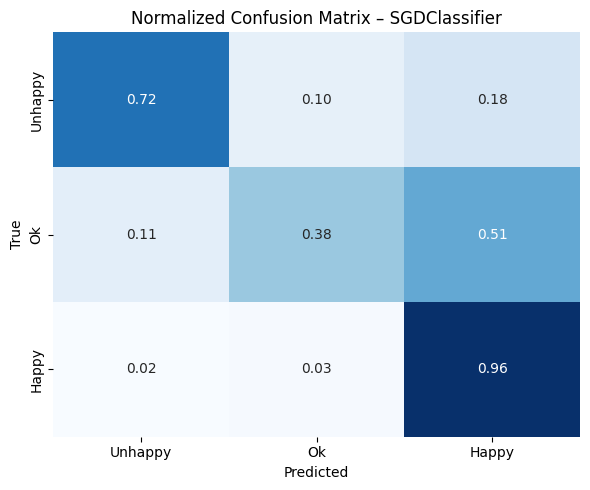

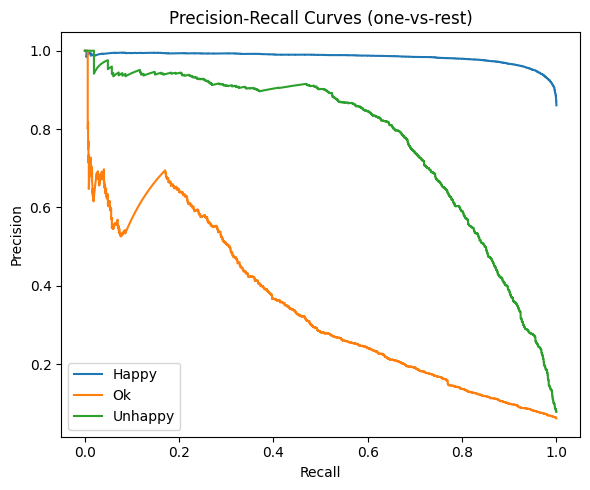

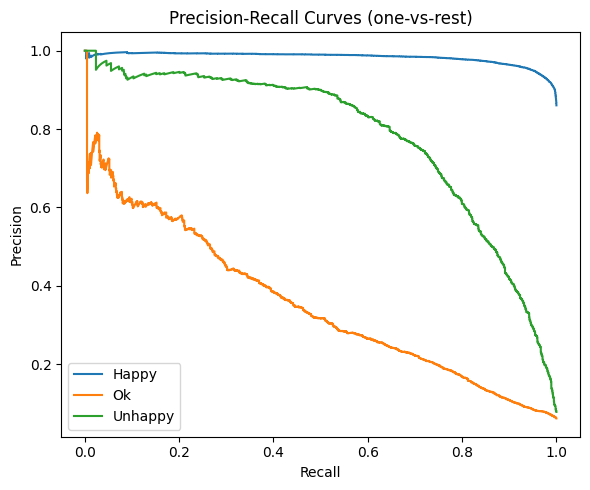

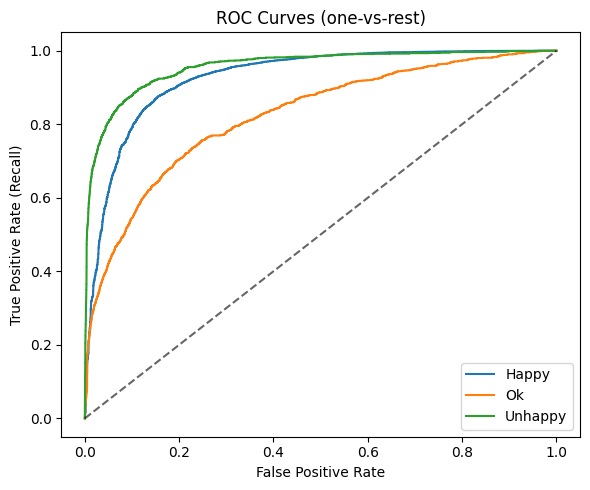

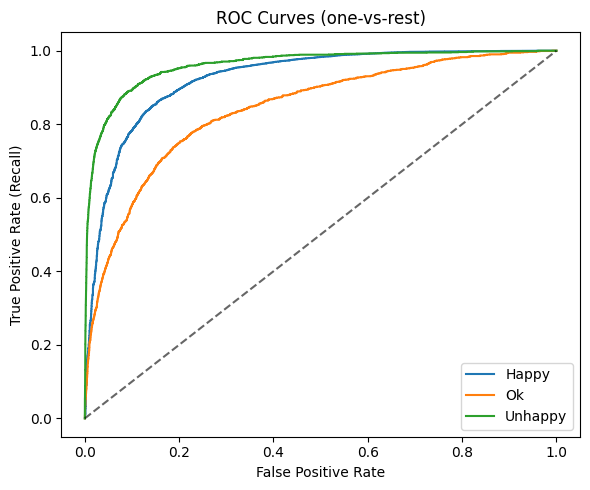

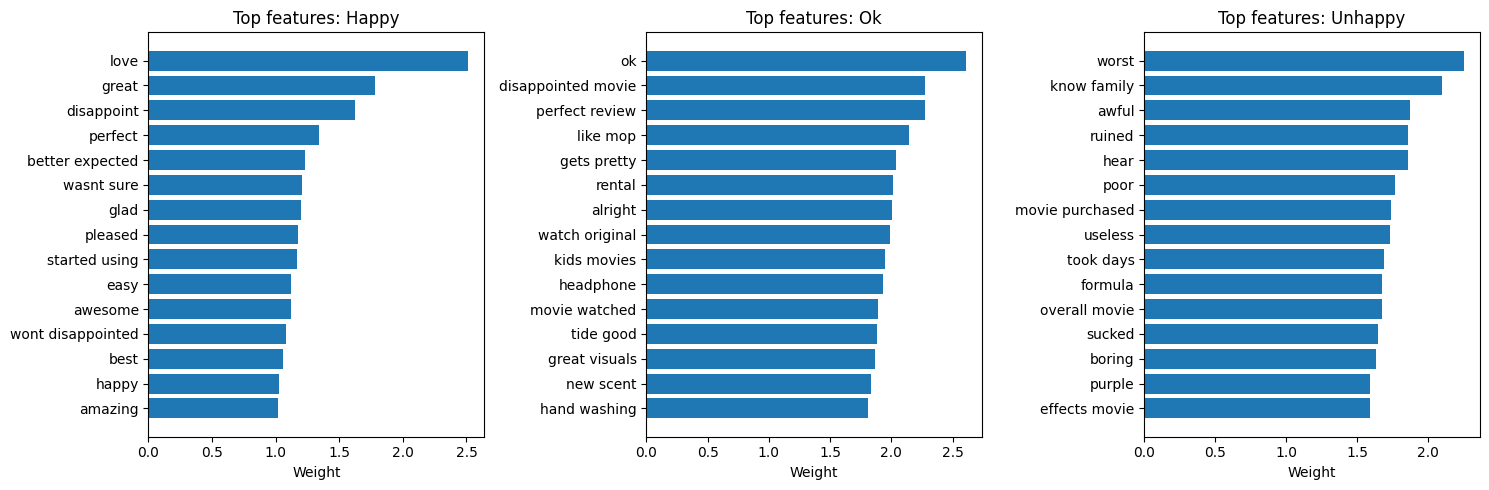

text     true     pred
0   two pack dvd first film jim carrey cameron dia...       Ok  Unhappy
1                 liked orig matthew broderick action       Ok    Happy
35  raunchy funny nonpc animated comedy uptight st...    Happy  Unhappy
39  okits weeks since ive put olay total effects t...       Ok    Happy
73             one least necessary worst sequels time  Unhappy       Ok
78                 flavor dark coffee prefect morning       Ok    Happy
87  frito products houston borderline stale sure q...  Unhappy    Happy
90  ive used product days every night found little...       Ok    Happy
95  buy bulk easy use kid use review collected par...       Ok    Happy
96  started apply little one rubbed eyes immediate...  Unhappy    Happy

In [46]:
# Predictions
y_test_pred_svm = svm_model.predict(X_test)
y_test_pred_sgd = sgd_model.predict(X_test)

print('SVM report')
print(classification_report(y_test, y_test_pred_svm))
print('SGD report')
print(classification_report(y_test, y_test_pred_sgd))

# Confusion matrices
plot_confusion_matrix(y_test, y_test_pred_svm, title='Normalized Confusion Matrix – Linear SVM')
plot_confusion_matrix(y_test, y_test_pred_sgd, title='Normalized Confusion Matrix – SGDClassifier')

# PR + ROC curves
labels = list(svm_model.classes_)
svm_scores = svm_model.decision_function(X_test)
sgd_scores = sgd_model.decision_function(X_test)
plot_precision_recall_curves(y_test, svm_scores, labels)
plot_precision_recall_curves(y_test, sgd_scores, labels)
plot_roc_curves(y_test, svm_scores, labels)
plot_roc_curves(y_test, sgd_scores, labels)

# Top features
feature_names = np.hstack([
    np.array(char_vec.get_feature_names_out()),
    np.array(word_vec.get_feature_names_out()),
])
plot_top_features(svm_model.coef_, feature_names, labels, top_k=15)

# Error samples
misclassified = pd.DataFrame({
    'text': text_test.reset_index(drop=True),
    'true': pd.Series(y_test).reset_index(drop=True),
    'pred': pd.Series(y_test_pred_svm),
})
misclassified[misclassified['true'] != misclassified['pred']].head(10)

## 6) Inference demo (unseen text)

In [47]:
demo_reviews = [
    'Absolutely love this laptop, fast delivery and great build quality.',
    'Battery died in two days and support never replied.',
    'Packaging was fine but the product feels cheap.'
]
demo_features = transform_texts(demo_reviews, word_vec, char_vec)
demo_preds = svm_model.predict(demo_features)
pd.DataFrame({'review': demo_reviews, 'predicted_sentiment': demo_preds})

review predicted_sentiment
0  Absolutely love this laptop, fast delivery and...               Happy
1  Battery died in two days and support never rep...               Happy
2    Packaging was fine but the product feels cheap.             Unhappy

## 7) Saved assets preview
The pipeline saves figures in `assets/`; you can also embed them in reports.

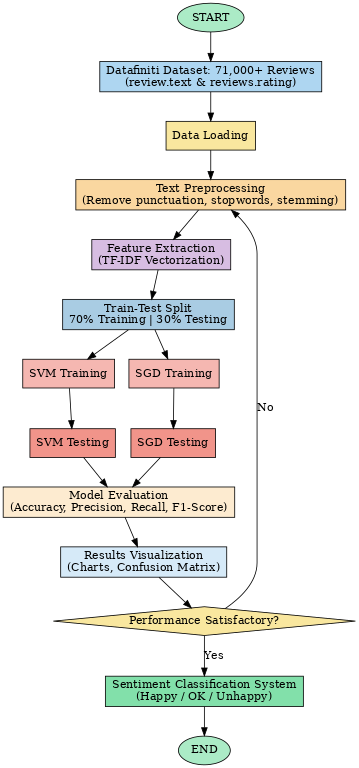

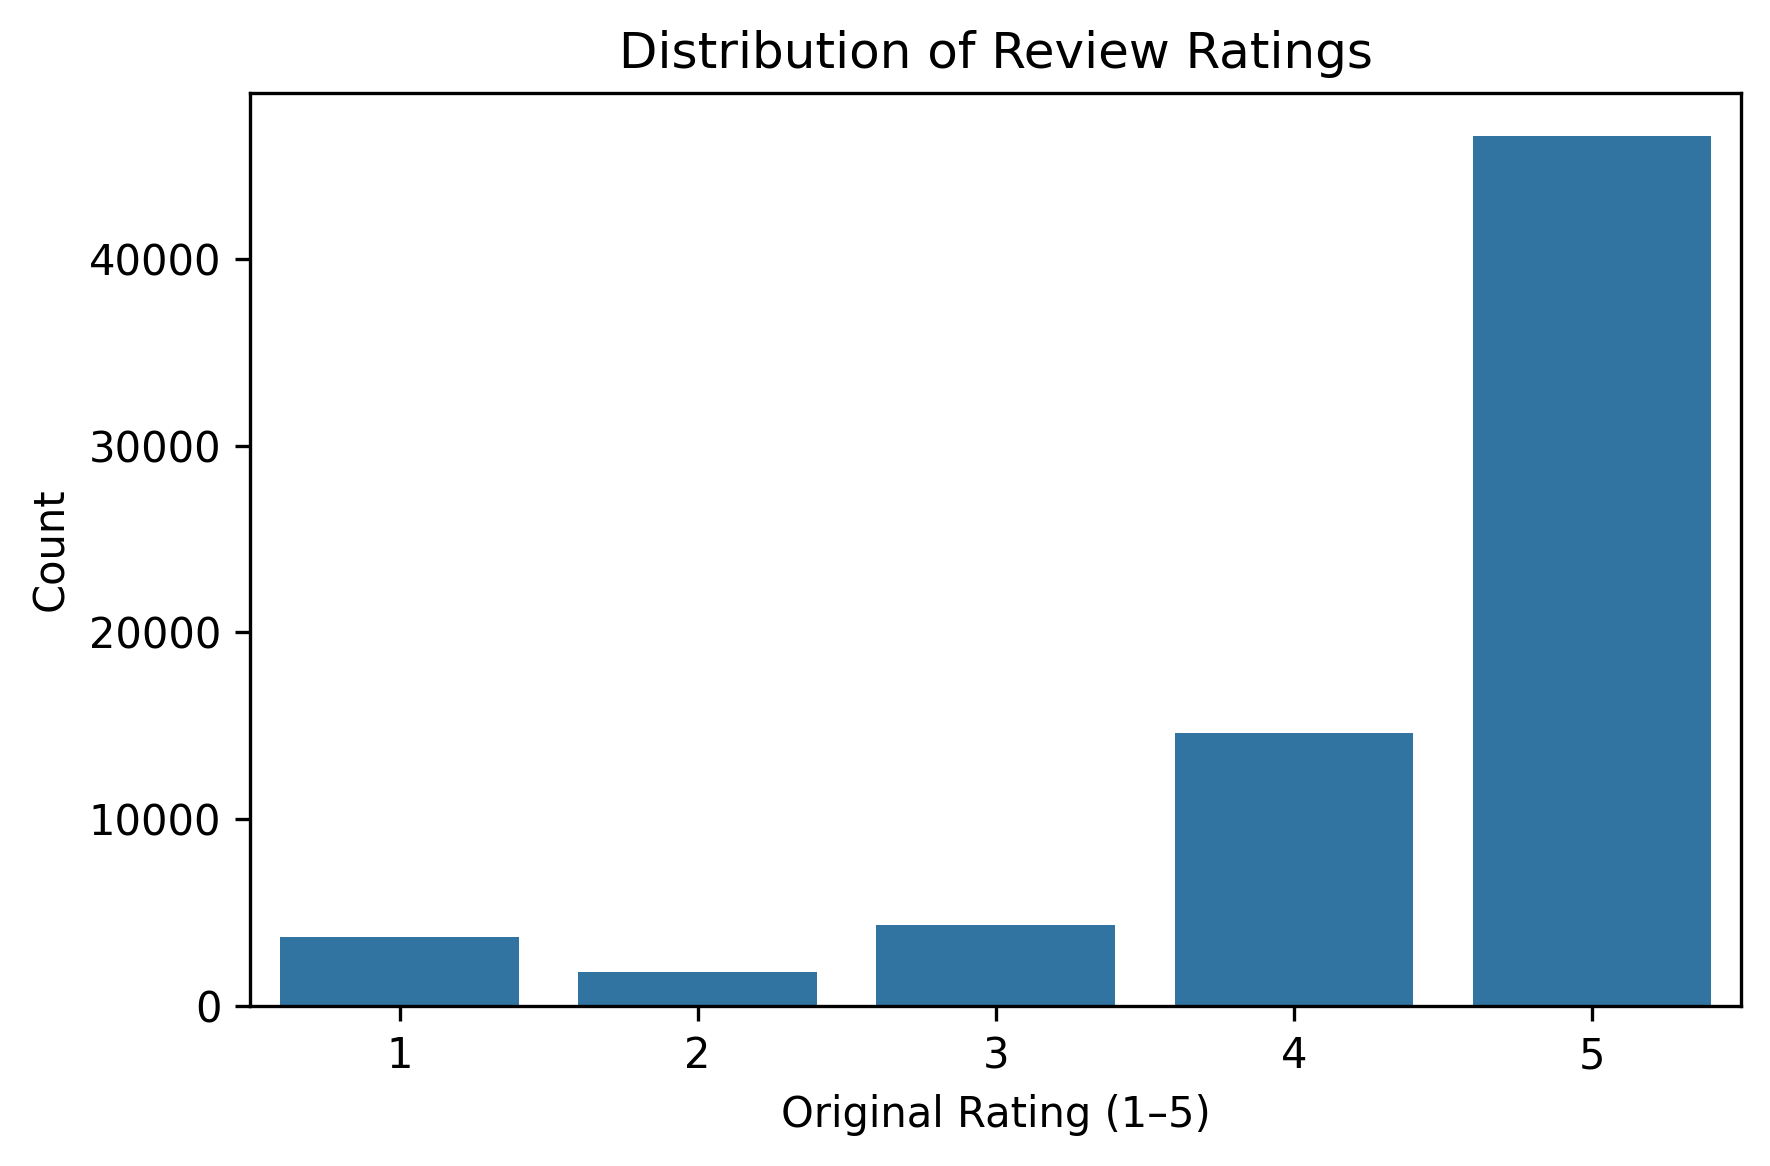

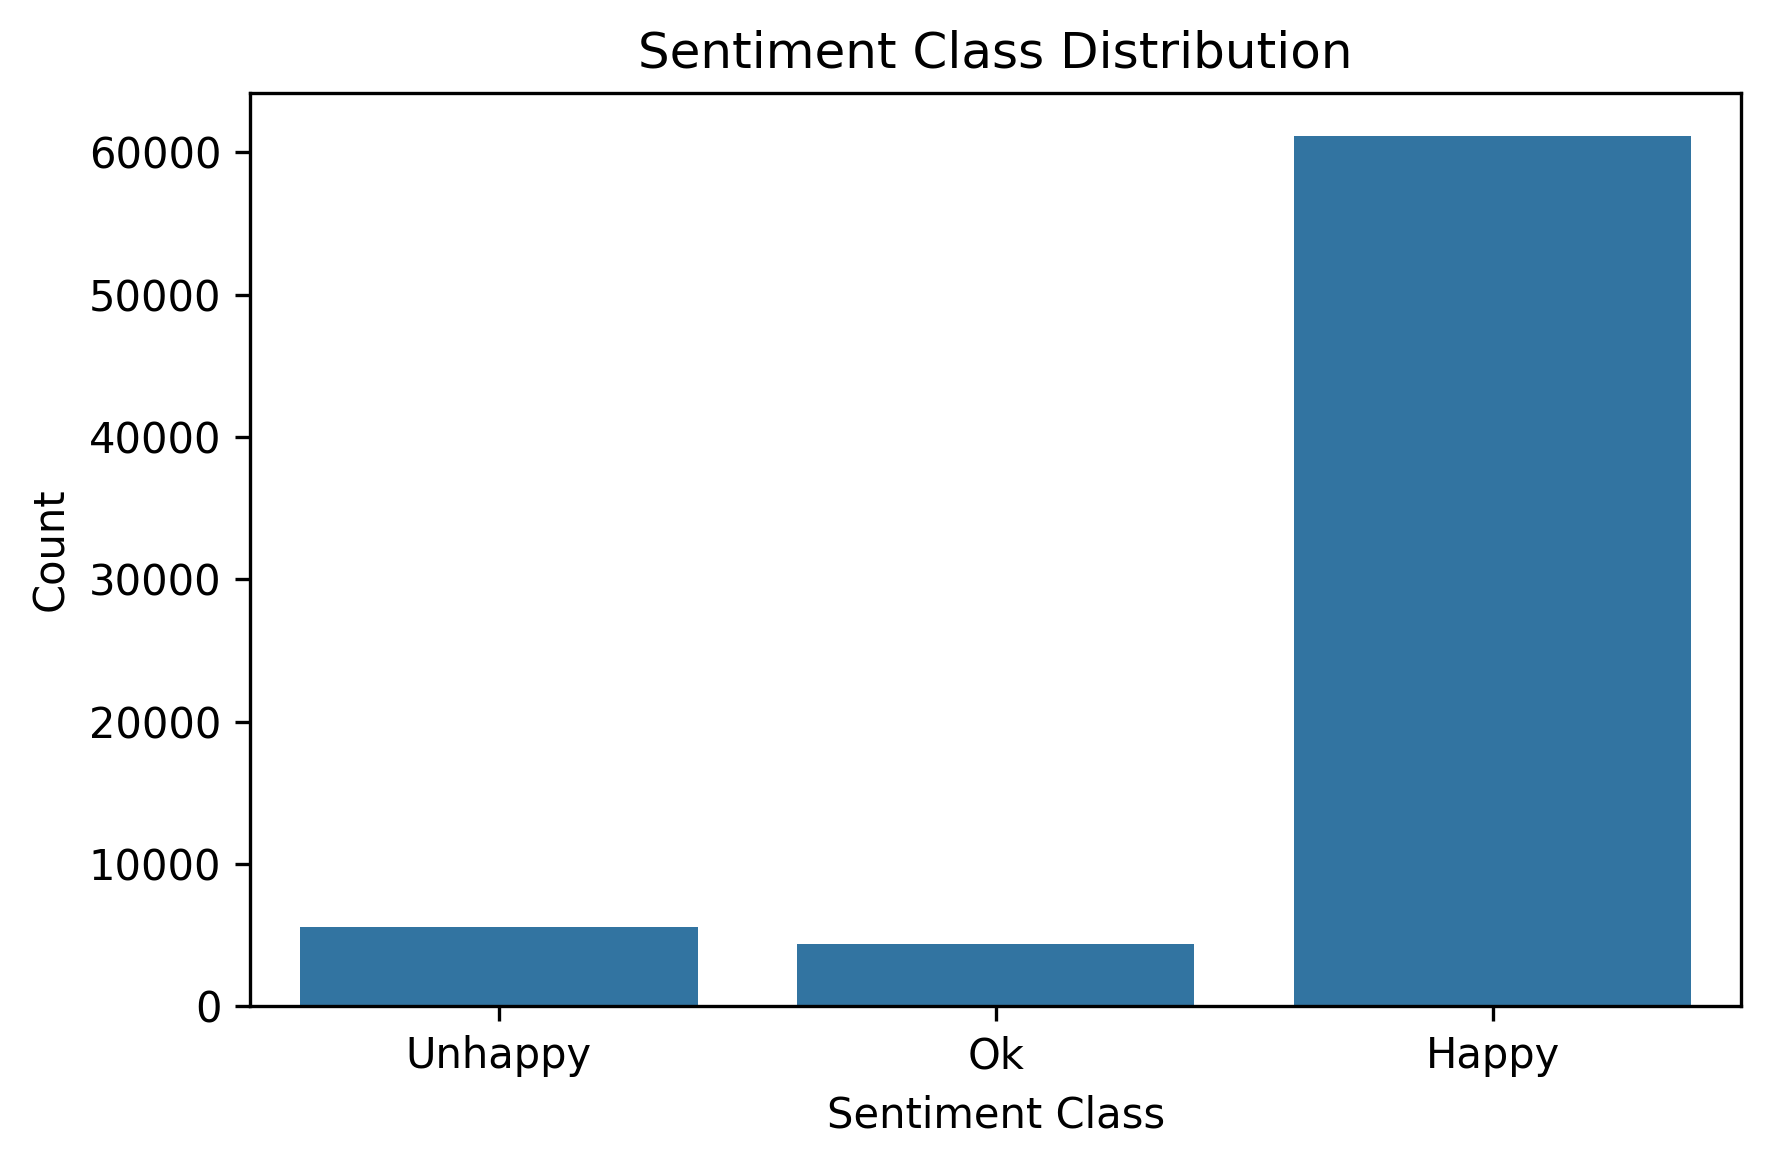

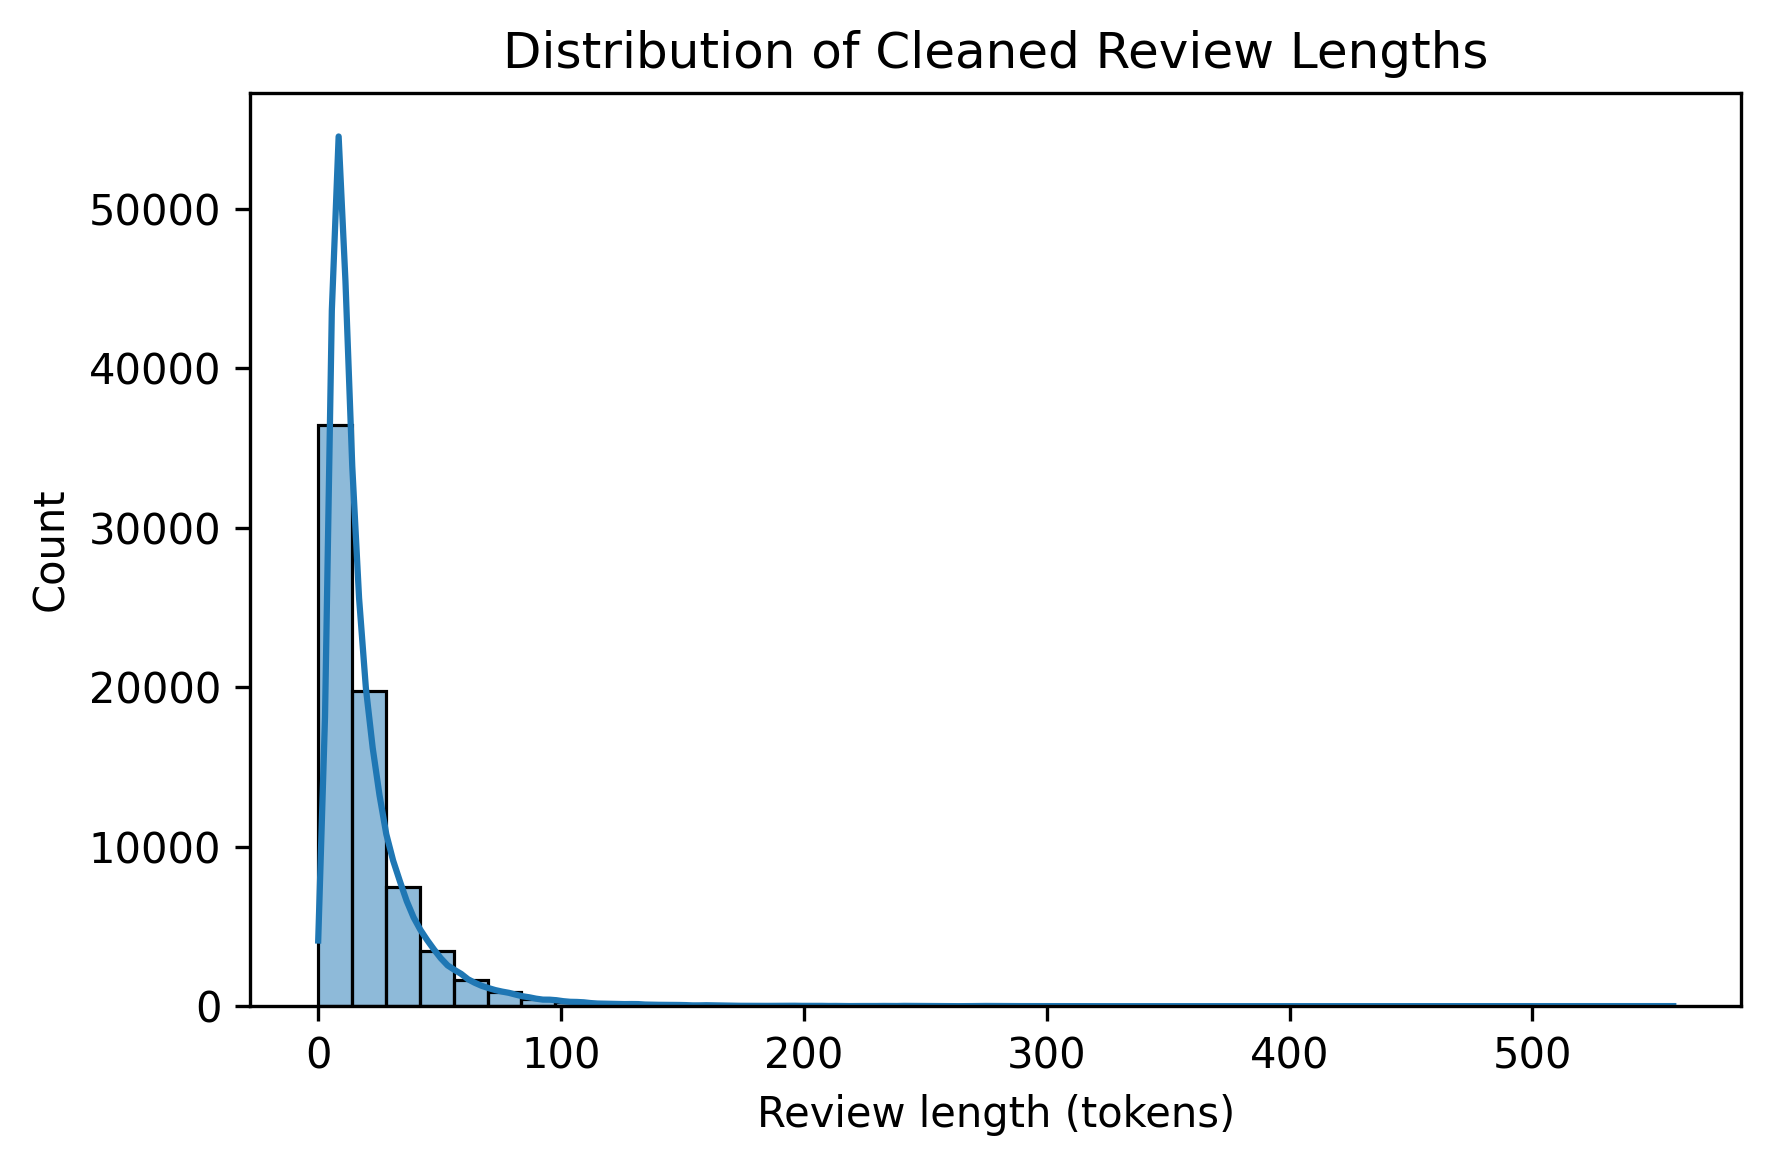

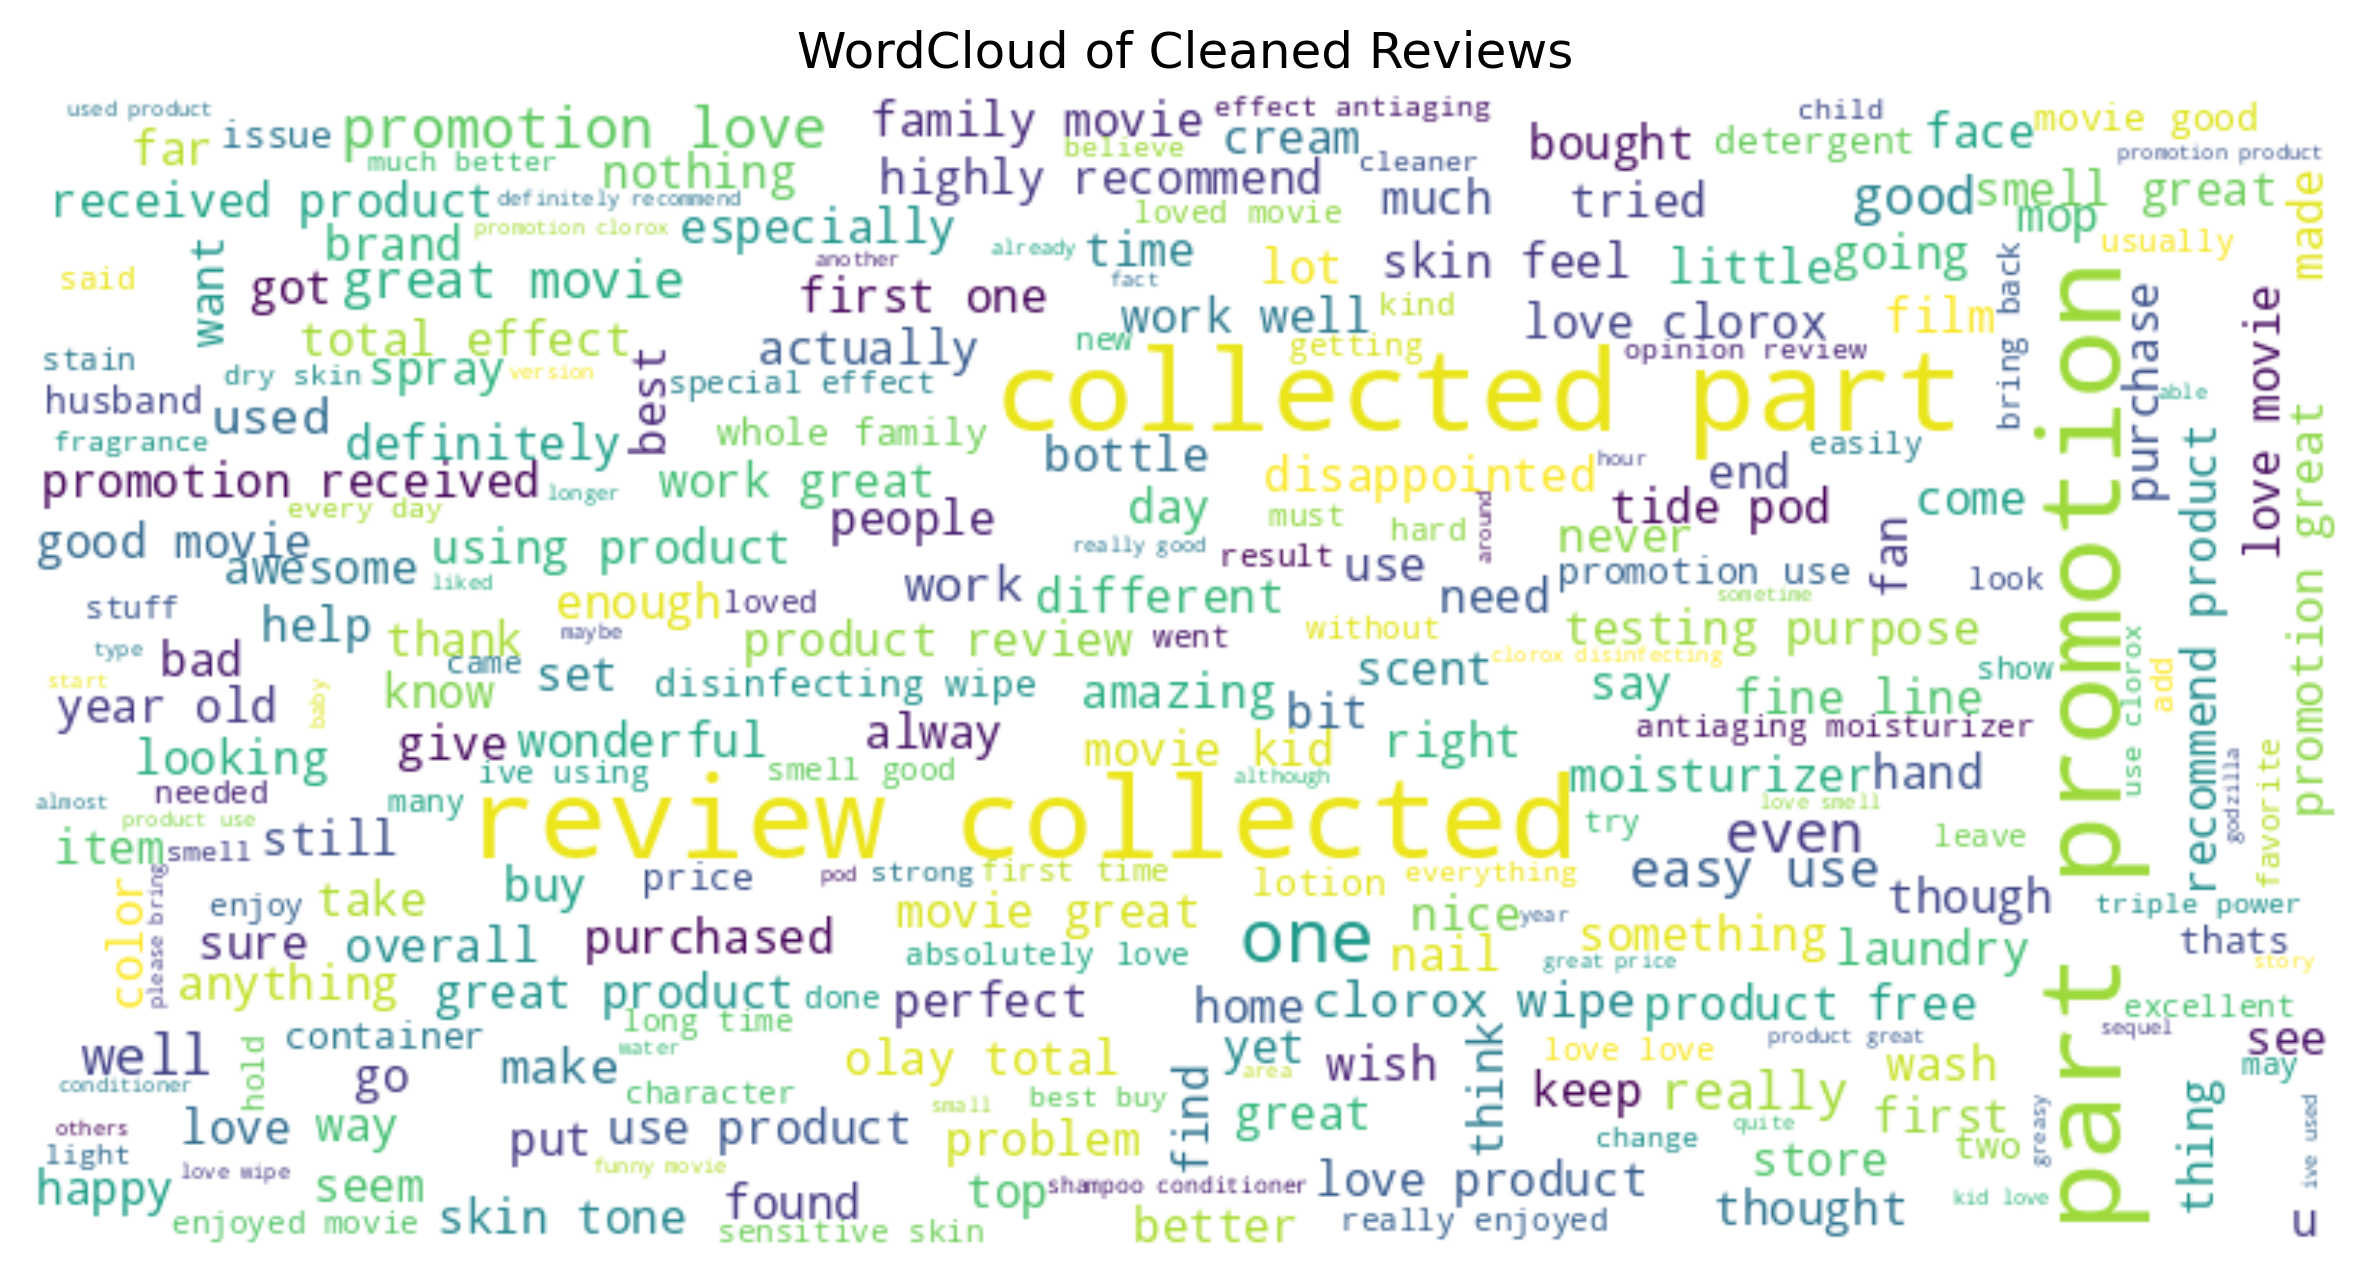

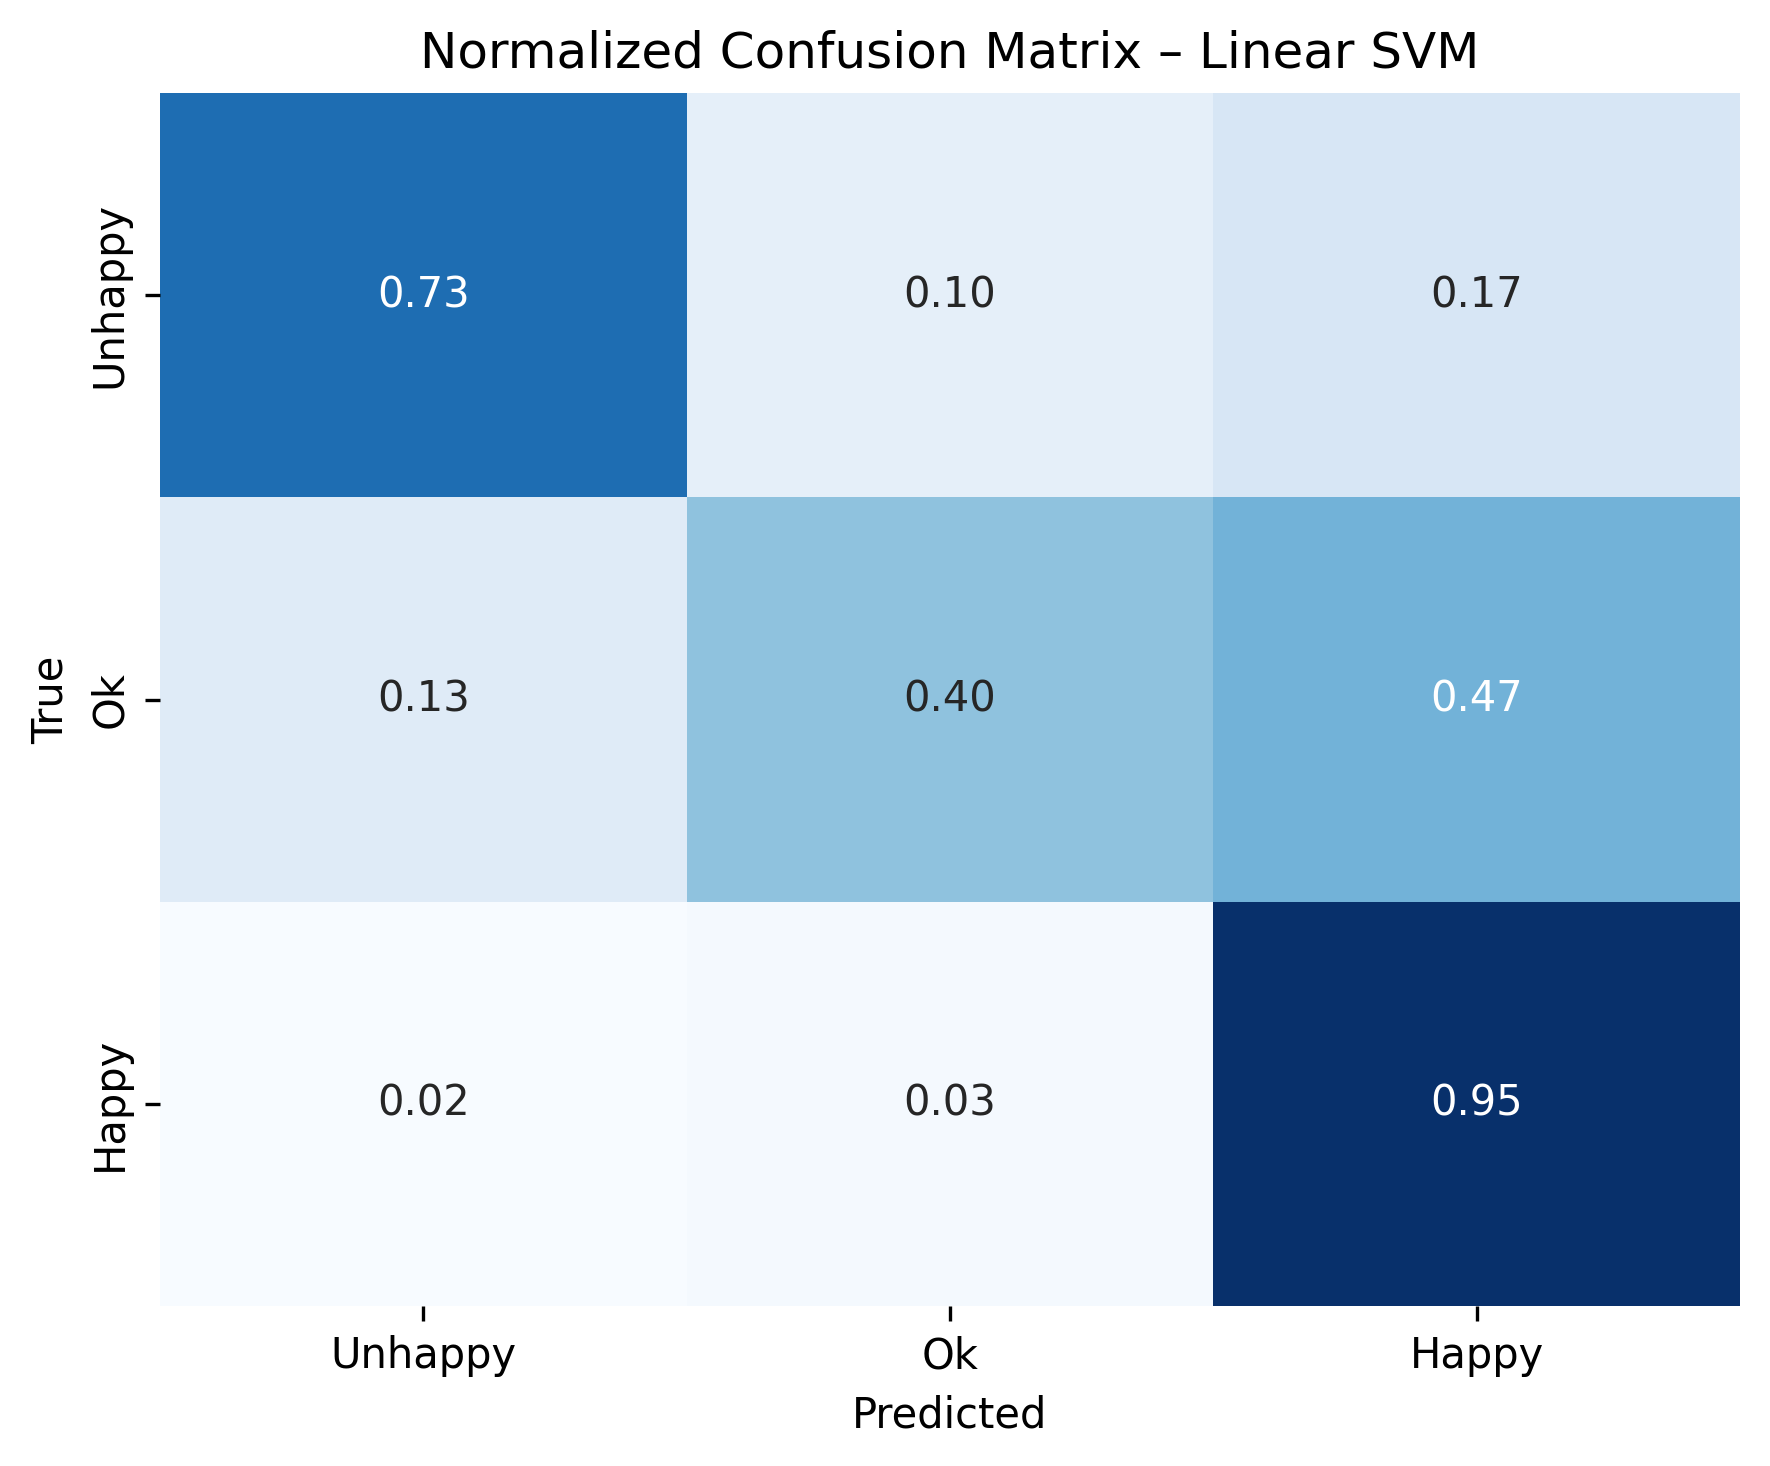

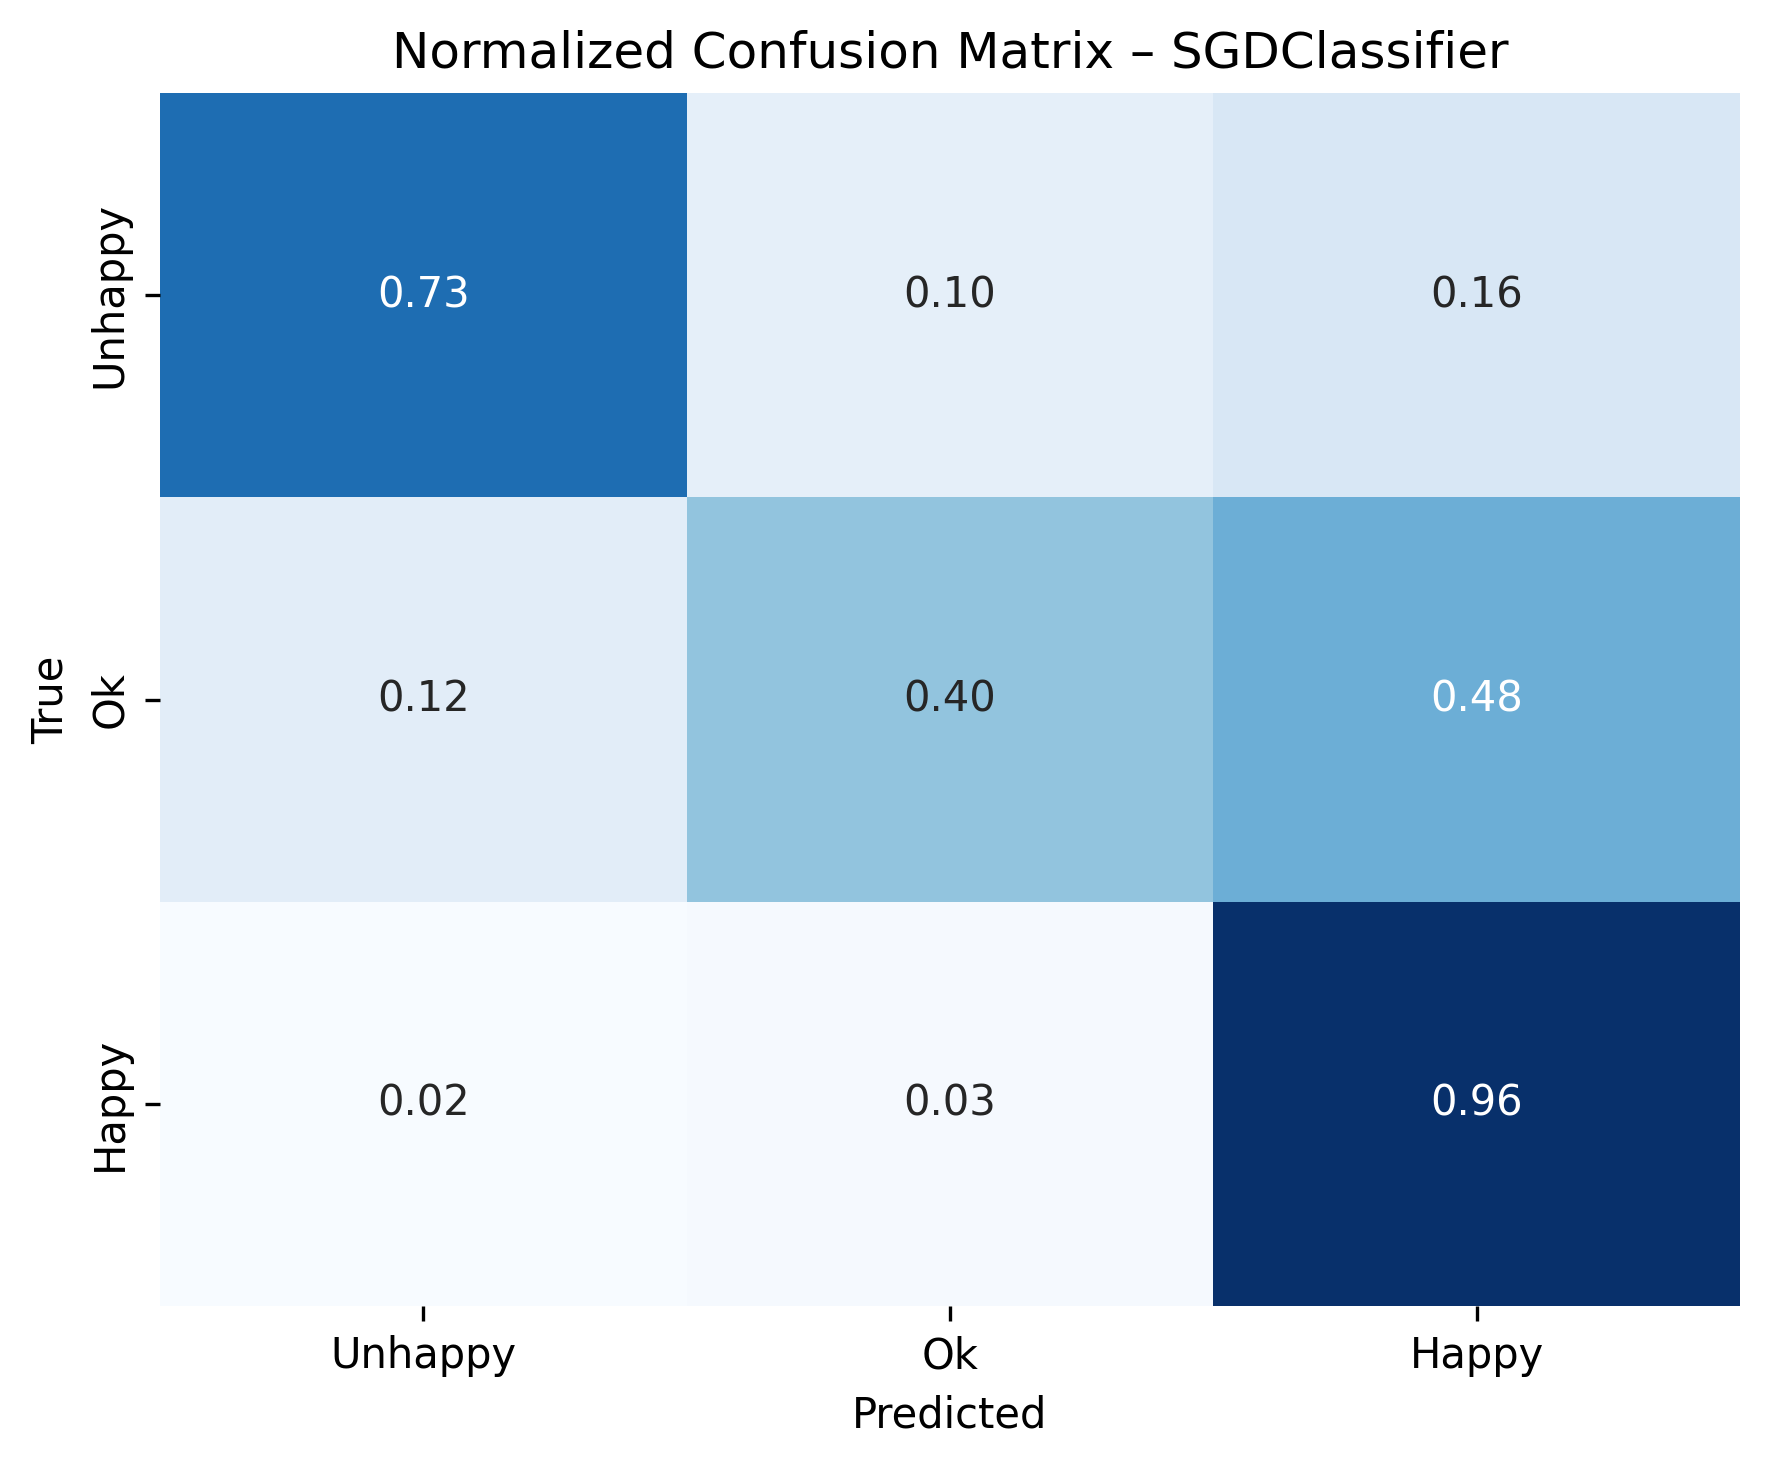

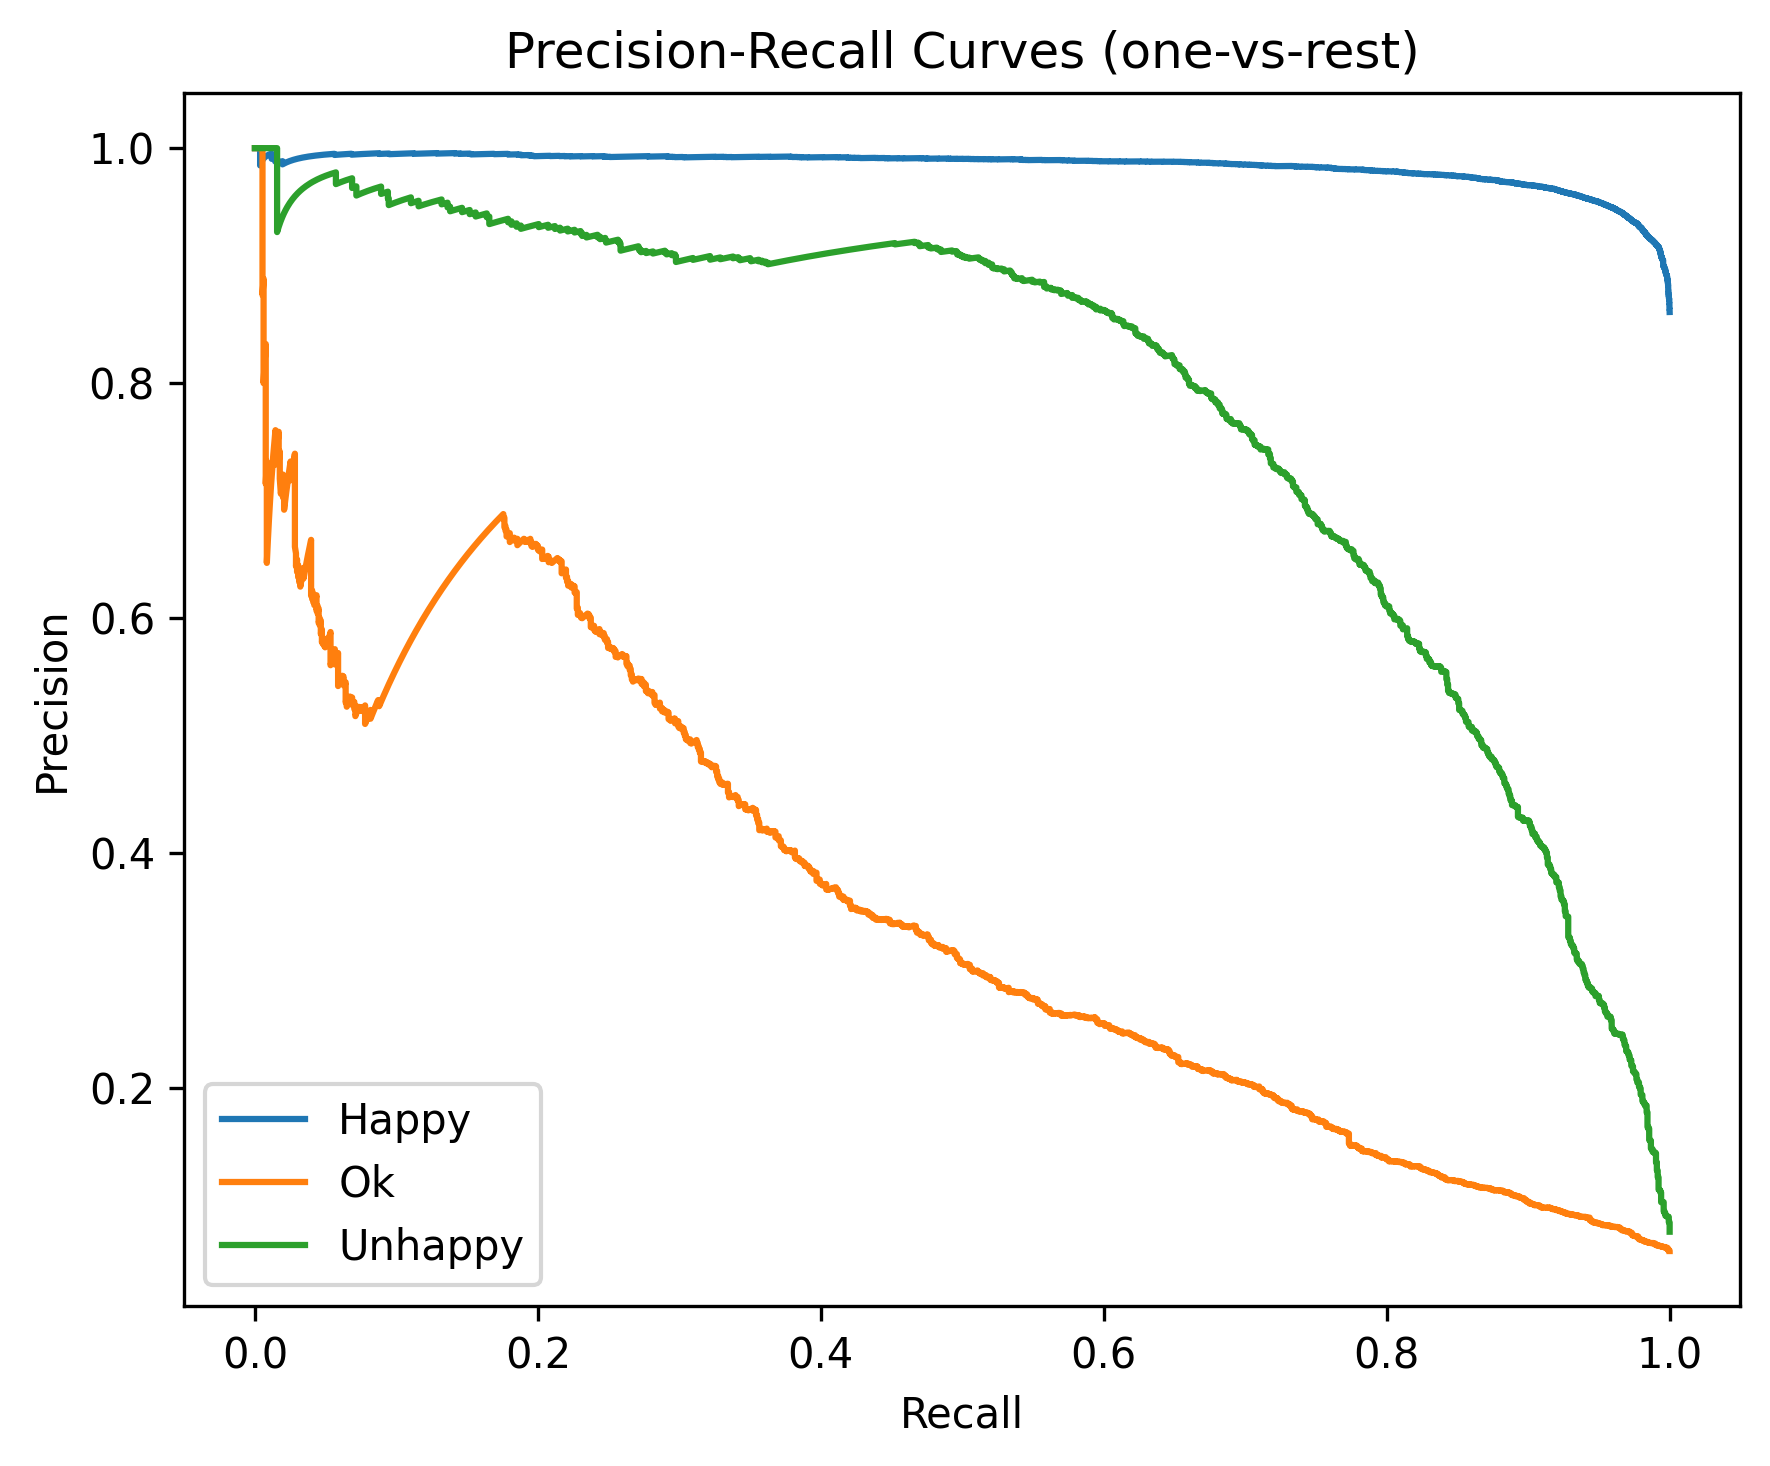

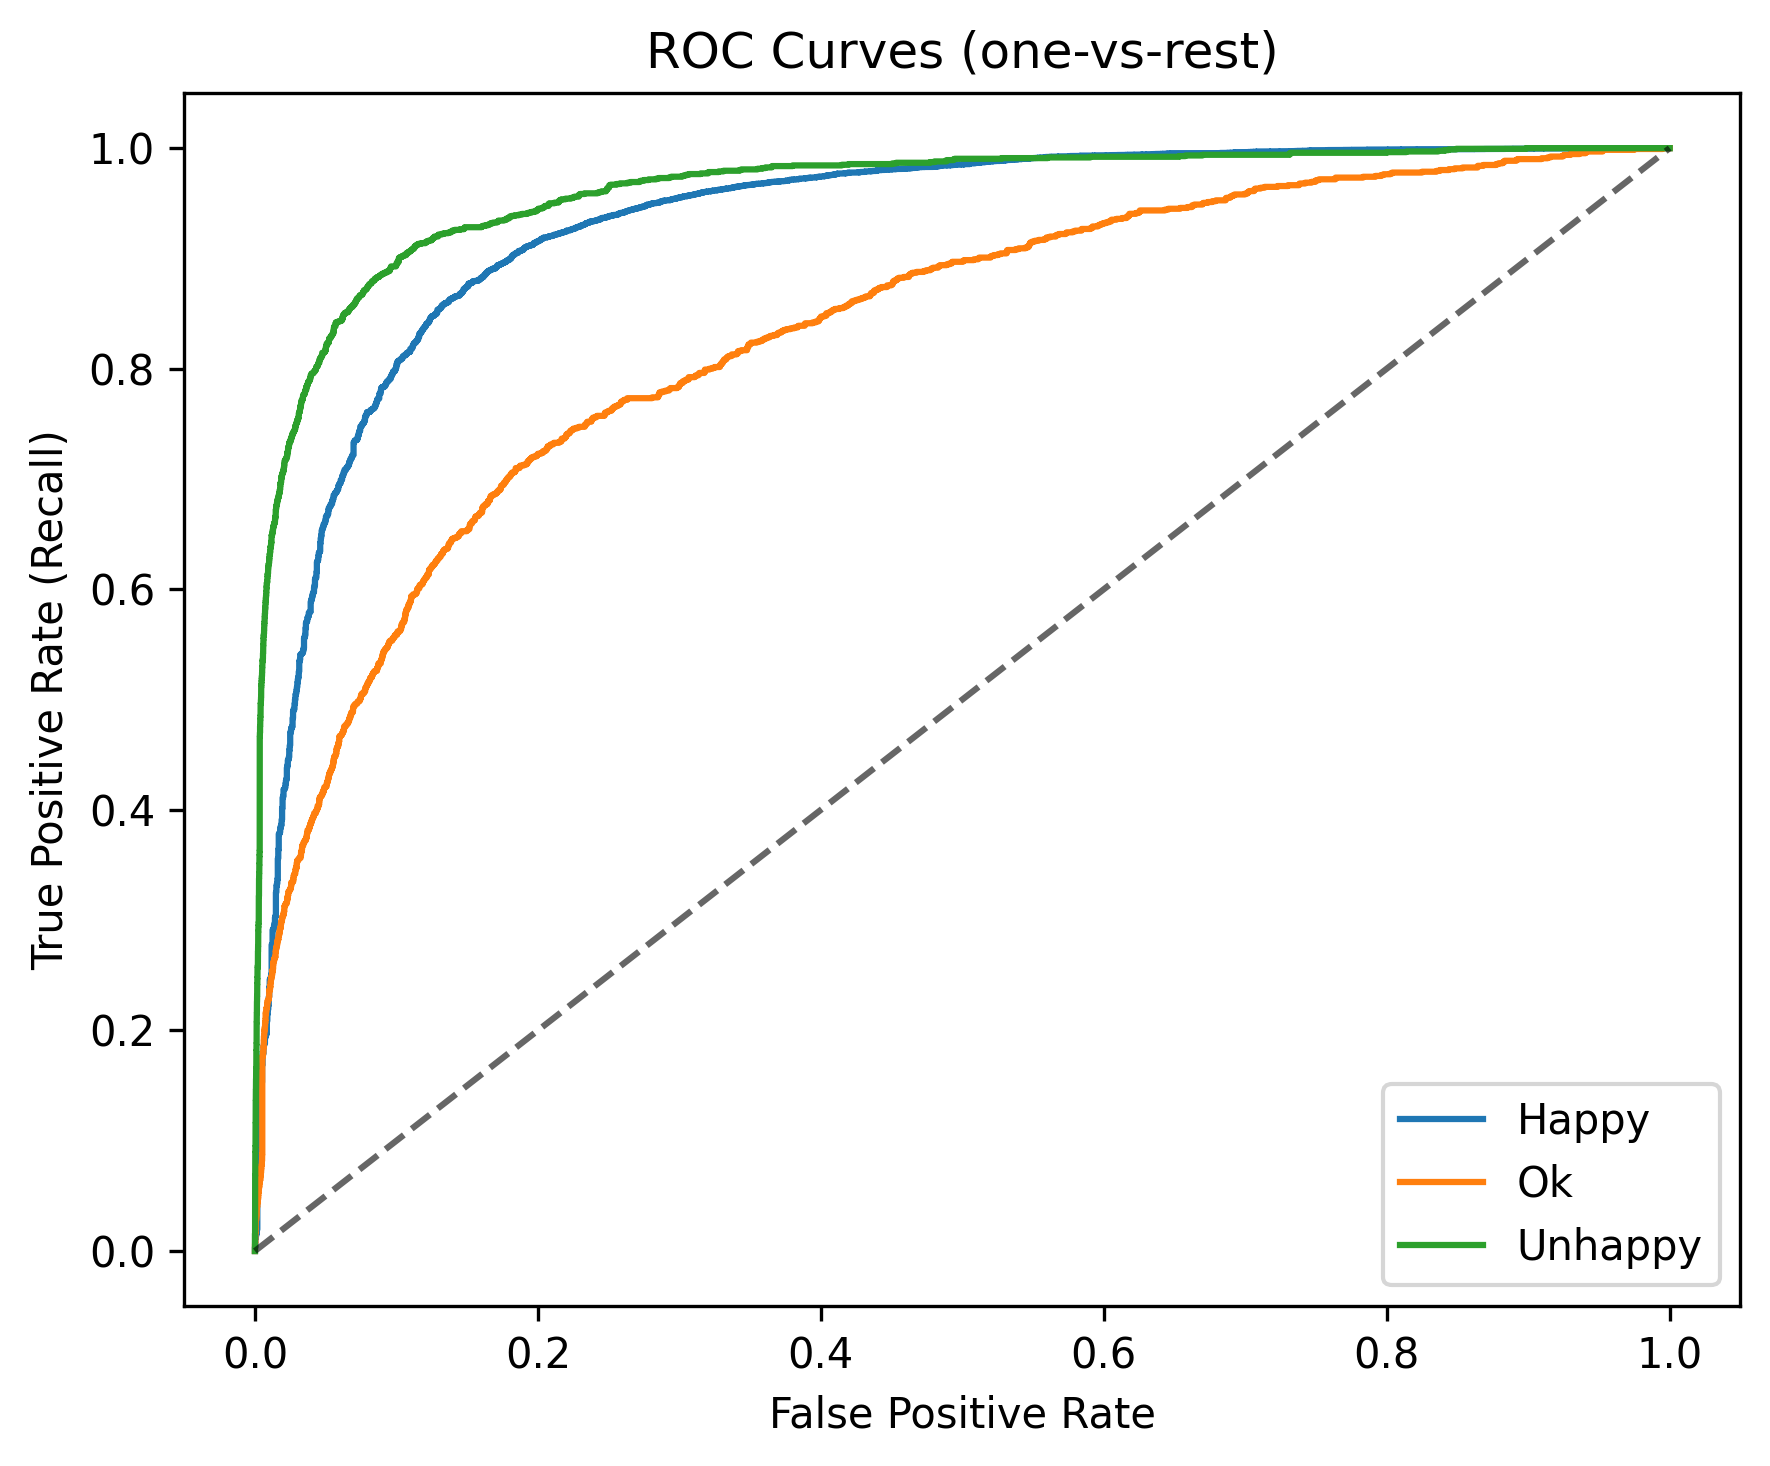

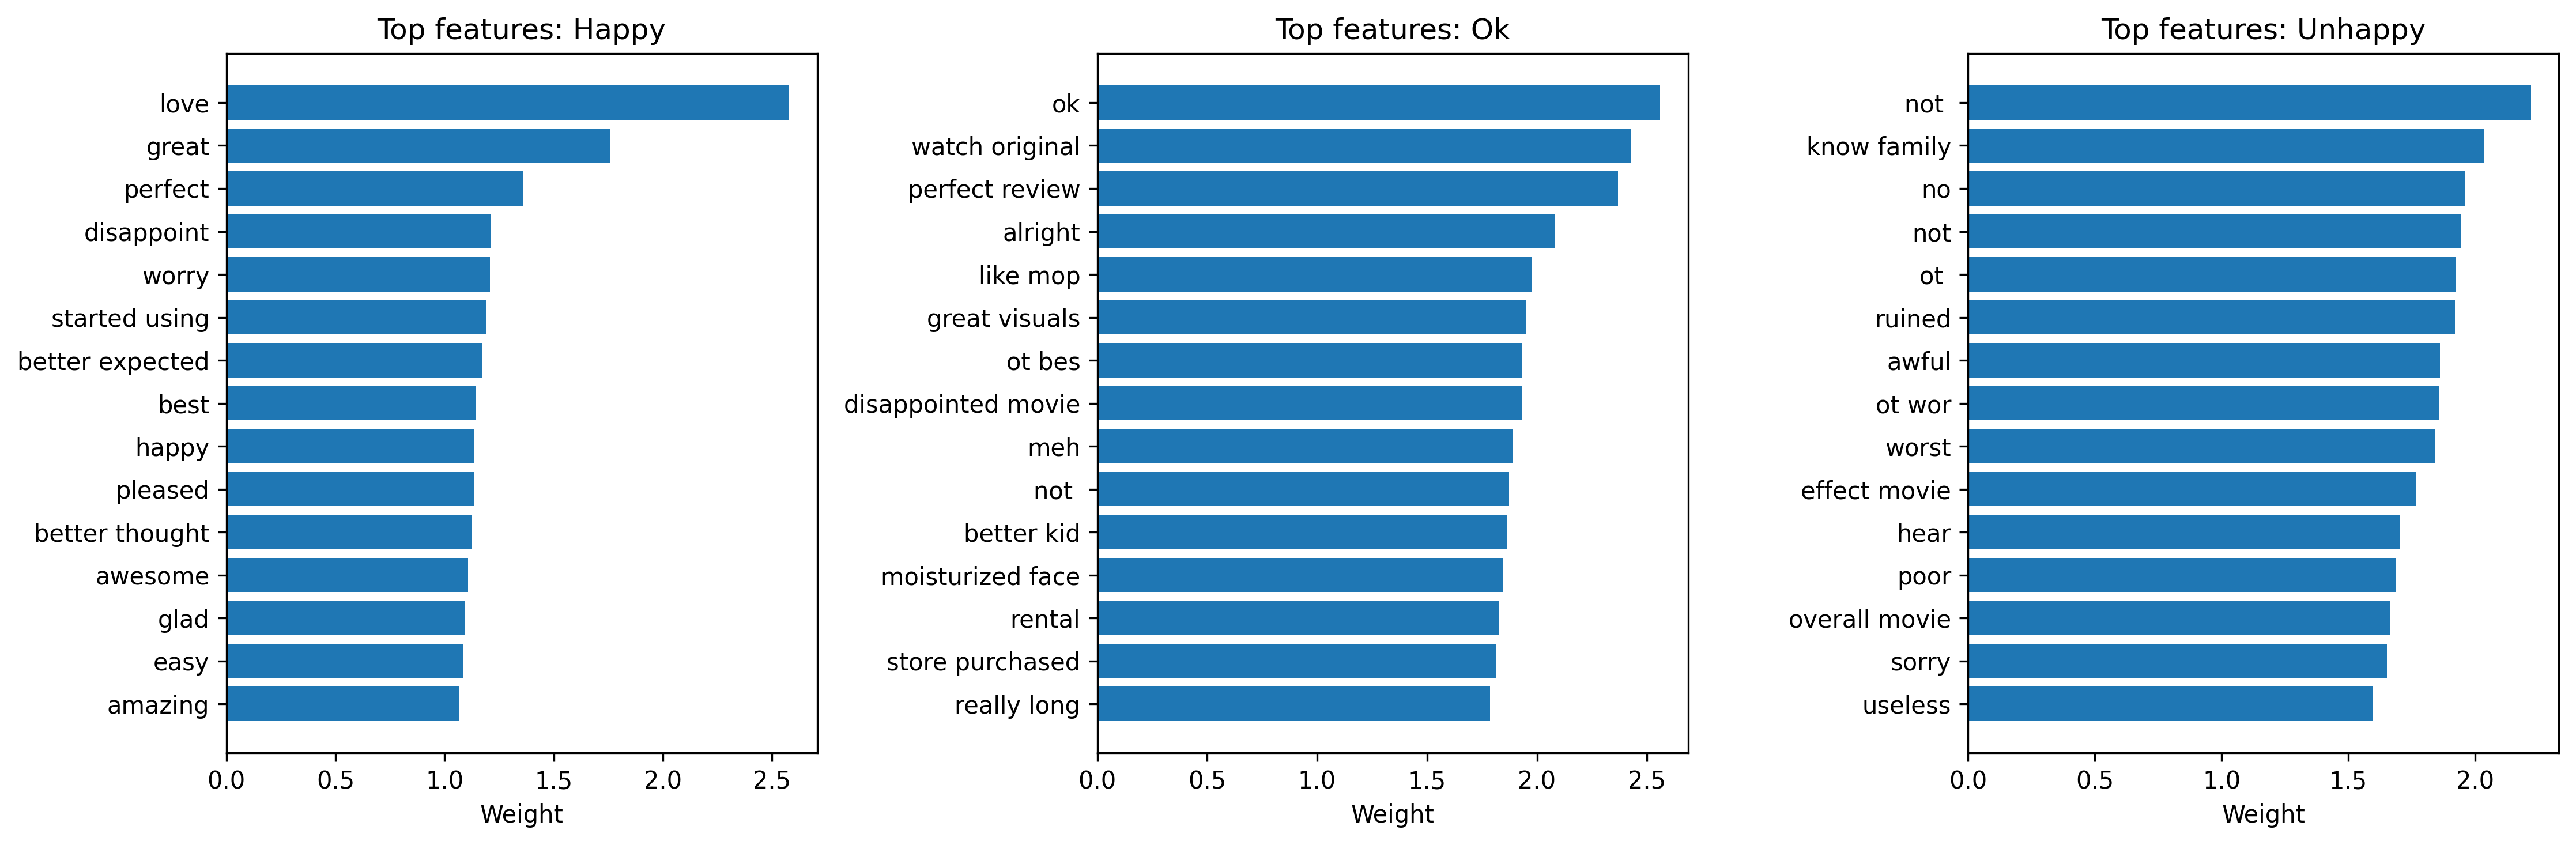

In [48]:
from IPython.display import Image, display
imgs = ['opinion_mining_flowchart.png', 'rating_histogram.png', 'class_distribution.png', 'length_distribution.png',
        'wordcloud_all.png', 'confusion_matrix_svm.png', 'confusion_matrix_sgd.png',
        'pr_curves_svm.png', 'roc_curves_svm.png', 'top_features_svm.png']
for name in imgs:
    path = Path('assets') / name
    if path.exists():
        display(Image(filename=str(path)))
    else:
        print(f'Missing: {path}')